In [1]:
import pandas as pd

In [3]:
import geopandas as gpd

In [5]:
import os

In [7]:
import matplotlib.pyplot as plt
from osgeo import gdal, osr

In [9]:
import rasterio

In [ ]:
### There are two different stacked Geotiffs for SOM- SOM_predictive.tif and SOM_predictive_1.tif"" each with different layers ####

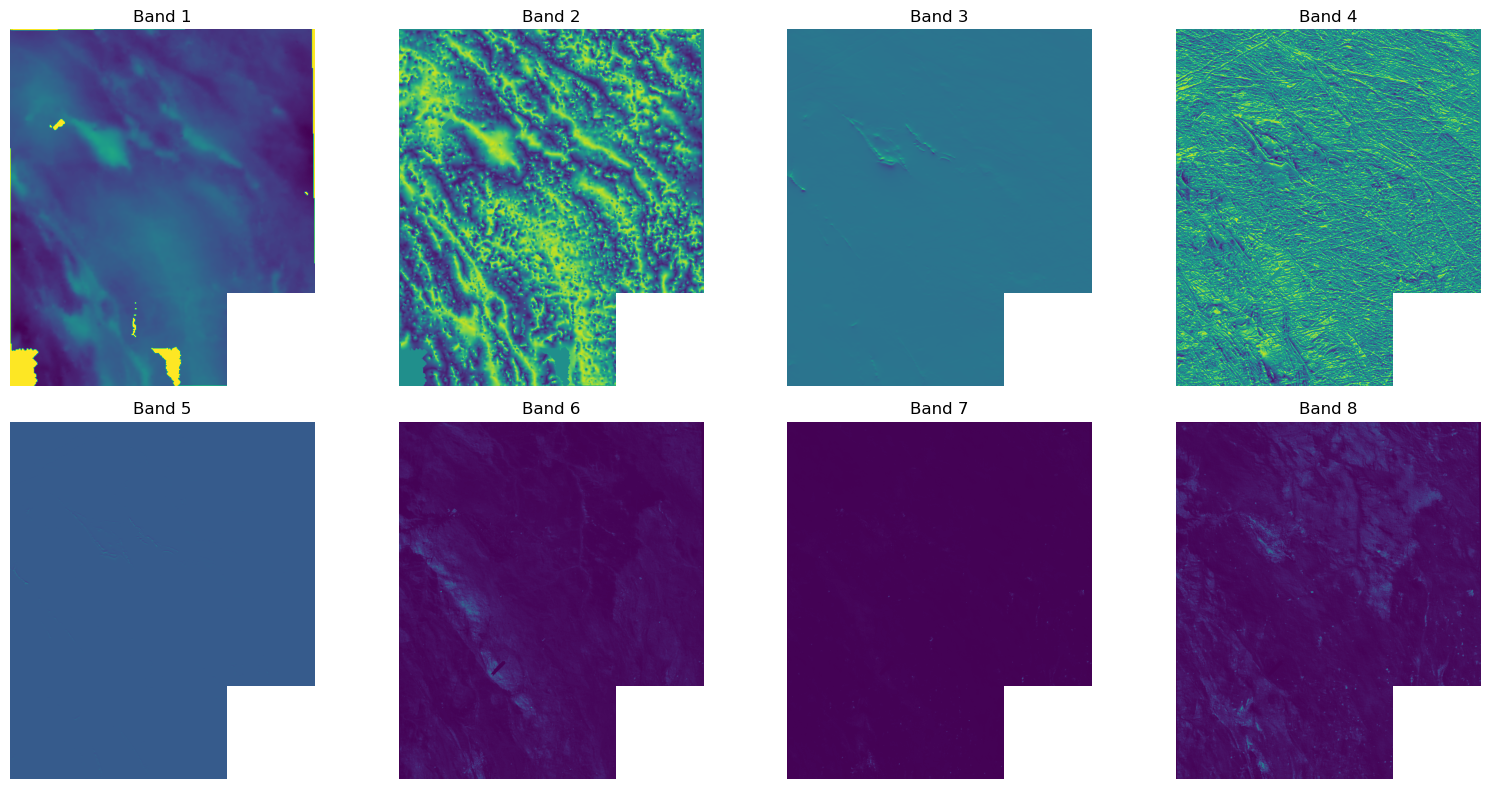

In [21]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open("GEOTIFF_org/SOM_predictive.tif") as src:
    band_count = src.count
    nodata = src.nodata
    bands = []

    for i in range(1, band_count + 1):
        band = src.read(i).astype('float32')  
        if nodata is None:
            band = np.where(band == nodata, np.nan, band)
        
        bands.append(band)

cols = 4
rows = int(np.ceil(len(bands) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

for i, band in enumerate(bands):
    r, c = divmod(i, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    im = ax.imshow(band, cmap="viridis")
    ax.set_title(f"Band {i + 1}")
    ax.axis("off")

for j in range(len(bands), rows * cols):
    r, c = divmod(j, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    ax.axis("off")

plt.tight_layout()
plt.show()


In [57]:
import rasterio
from rasterio.windows import from_bounds
import numpy as np

xmin, ymin, xmax, ymax = 742386, 1521300, 796417.39, 1578150

with rasterio.open('GEOTIFF_org/SOM_predictive_1.tif', 'r+') as src:
    window = from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
    
    nodata = src.nodata
    if nodata is None:
        nodata = np.nan  # or np.nan
        src.nodata = nodata


    data = src.read(window=window)
    
    data[:] = nodata
    
    src.write(data, window=window)


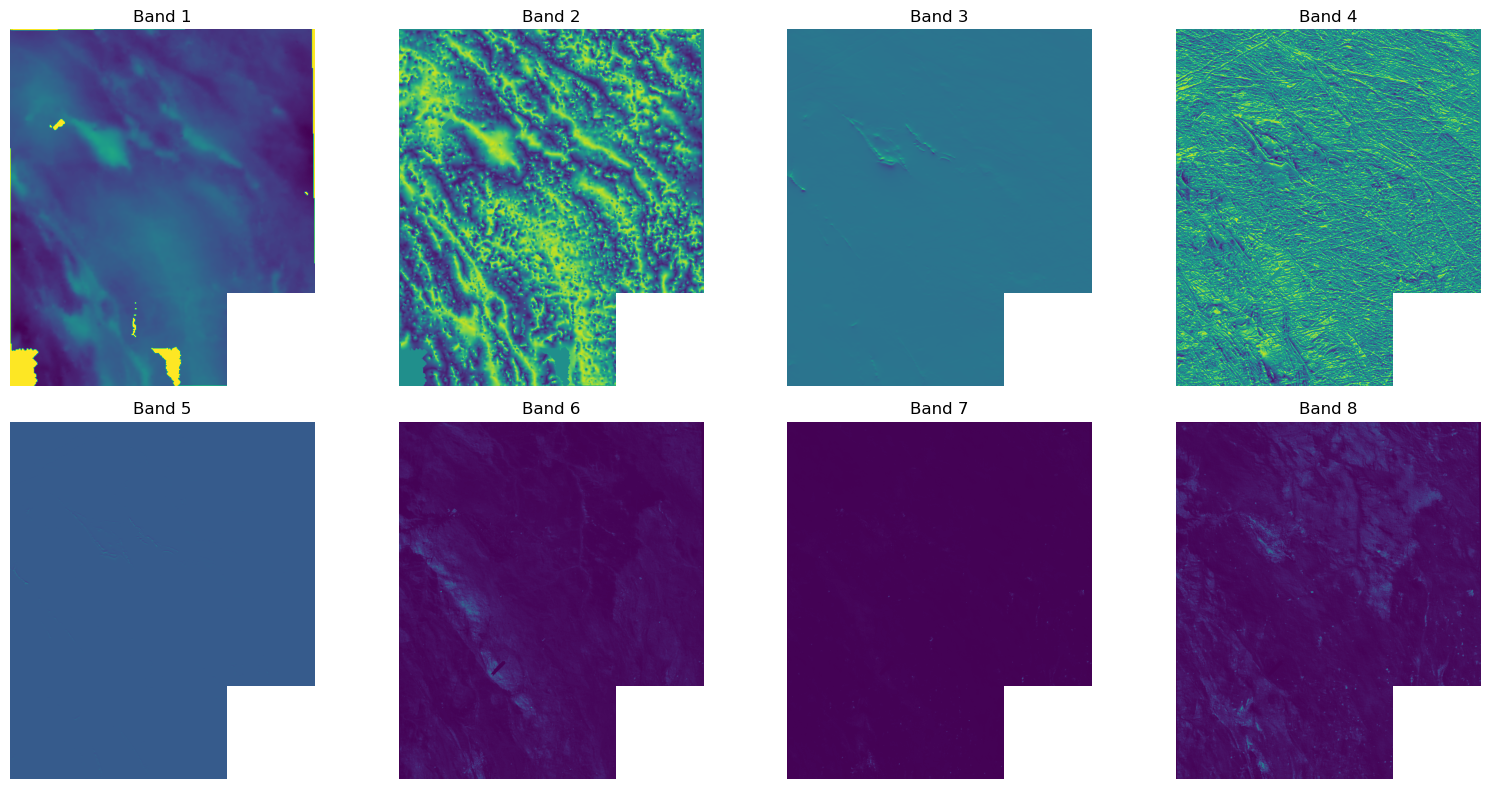

In [23]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the merged raster
with rasterio.open("GEOTIFF_org/SOM_predictive.tif") as src:
    band_count = src.count
    nodata = src.nodata
    bands = []

    for i in range(1, band_count + 1):
        band = src.read(i).astype('float32')  # Convert to float for NaN support
        if nodata is None:
            band = np.where(band == nodata, np.nan, band)
        #if src.nodata is not None:
        #    band[band == src.nodata] = np.nan
        bands.append(band)

# Plot all bands in a grid
cols = 4
rows = int(np.ceil(len(bands) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

for i, band in enumerate(bands):
    r, c = divmod(i, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    im = ax.imshow(band, cmap="viridis")
    ax.set_title(f"Band {i + 1}")
    ax.axis("off")

# Hide unused subplots if total bands < rows * cols
for j in range(len(bands), rows * cols):
    r, c = divmod(j, cols)
    ax = axes[r, c] if rows > 1 else axes[c]
    ax.axis("off")

plt.tight_layout()
plt.show()


In [145]:
import rasterio
import pandas as pd
from rasterio.transform import xy
import numpy as np

with rasterio.open("GEOTIFF_org/SOM_predictive.tif") as src:
    band_count = src.count
    bands = [src.read(i + 1).flatten() for i in range(band_count)]  
    rows, cols = src.shape  

   
    coords = [xy(src.transform, row, col) for row in range(rows) for col in range(cols)]
    xs, ys = zip(*coords)

data = {
    "Longitude": xs,
    "Latitude": ys,
}

for i, band in enumerate(bands, 1):
    data[f"Band_{i}"] = band

# Convert to DataFrame
df_SOM = pd.DataFrame(data)

In [147]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def load_geotiff(file_path):
    with rasterio.open(file_path) as src:
        data = src.read()  
        profile = src.profile  
    return data, profile

file_path = "GEOTIFF_org/SOM_predictive.tif"
data, profile = load_geotiff(file_path)

data_reshaped = data.reshape(data.shape[0], -1).T  
data_cleaned = data_reshaped[~np.isnan(data_reshaped).any(axis=1)]  

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_cleaned)


In [149]:
data_scaled

array([[1.        , 0.4968746 , 0.38360065, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.4968746 , 0.38360065, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.4968746 , 0.38360065, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.4968746 , 0.38360065, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.4968746 , 0.38360065, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.4968746 , 0.38360065, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [151]:
np.sum(np.isnan(data_scaled))

0

In [153]:
som = MiniSom(x = 4, y = 4, input_len = data_scaled.shape[1], sigma = 0.5, learning_rate = 0.5,neighborhood_function='gaussian', random_seed=42)

In [155]:
som.random_weights_init(data_scaled)

In [157]:
som.train_random(data_scaled, num_iteration=1000)

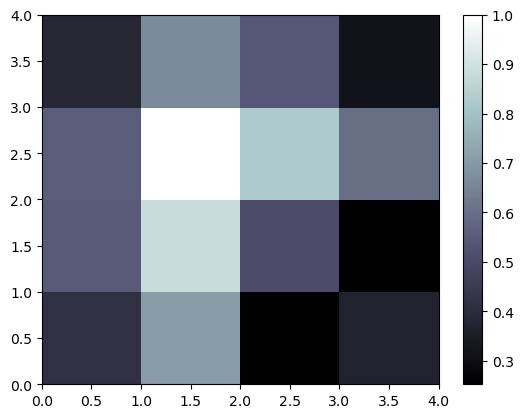

In [159]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']


show()

In [161]:
winner_coordinates = np.array([som.winner(x) for x in data_scaled])

In [163]:
cluster_map = np.ravel_multi_index(winner_coordinates.T, (4,4))


In [165]:
clustered_raster = np.full(data_reshaped.shape[0], np.nan)  
clustered_raster[~np.isnan(data_reshaped).any(axis=1)] = cluster_map  
clustered_raster = clustered_raster.reshape(profile["height"], profile["width"])

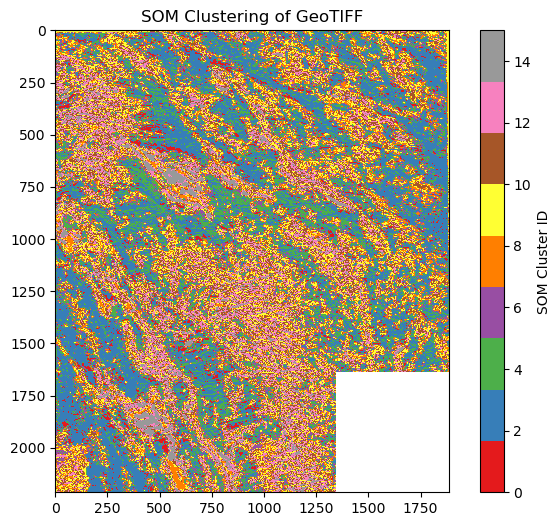

In [167]:
plt.figure(figsize=(8, 6))
plt.imshow(clustered_raster, cmap="Set1")
plt.colorbar(label="SOM Cluster ID")
plt.title("SOM Clustering of GeoTIFF")
plt.show()

In [169]:
df_SOM.isna().sum()

Longitude         0
Latitude          0
Band_1       306720
Band_2       306720
Band_3       306720
Band_4       306720
Band_5       306720
Band_6       306720
Band_7       306720
Band_8       306720
dtype: int64

In [171]:
df_SOM = df_SOM.dropna()

In [173]:
import numpy as np


winners = np.array([som.winner(x) for x in data_scaled])

cluster_map = {(i, j): f'Cluster{i * 4 + j}' for i in range(4) for j in range(4)}

clusters = np.array([cluster_map[tuple(w)] for w in winners])

df_SOM['Cluster'] = clusters


In [175]:
import geopandas as gpd
df_SOM_gdf = gpd.GeoDataFrame(df_SOM, geometry=gpd.points_from_xy(df_SOM.Longitude, df_SOM.Latitude), crs="EPSG:32643")

/var/folders/cj/c3lxhrz916l_n171dhdhbg8h0000gp/T/ipykernel_37188/726585466.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend2 = ax.legend(bbox_to_anchor=(1.3, 0.6), loc='upper left')


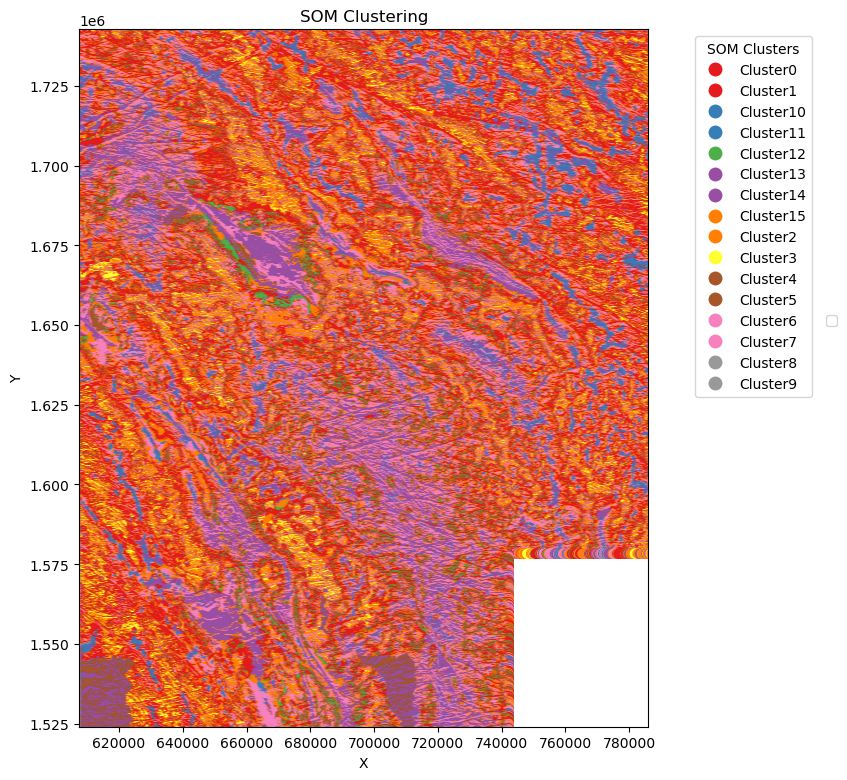

In [177]:
fig, ax = plt.subplots(figsize=(8,8))
df_SOM_gdf.plot(ax=ax,column='Cluster', cmap='Set1', legend=True)

legend1 = ax.get_legend()
if legend1:
    legend1.set_bbox_to_anchor((1.3, 1))  # Move legend further right
    legend1.set_title("SOM Clusters")
legend2 = ax.legend(bbox_to_anchor=(1.3, 0.6), loc='upper left')

plt.subplots_adjust(right=0.8)



plt.xlabel("X")
plt.ylabel("Y")
plt.title("SOM Clustering")
ax.set_xlim(607500, 786000)
ax.set_ylim(1524000, 1742700)
ax.add_artist(legend1)
plt.tight_layout()
plt.savefig("SOM_predictive.jpg")
plt.show()

/var/folders/cj/c3lxhrz916l_n171dhdhbg8h0000gp/T/ipykernel_37188/3729929444.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend2 = ax.legend(bbox_to_anchor=(1.3, 0.6), loc='upper left')


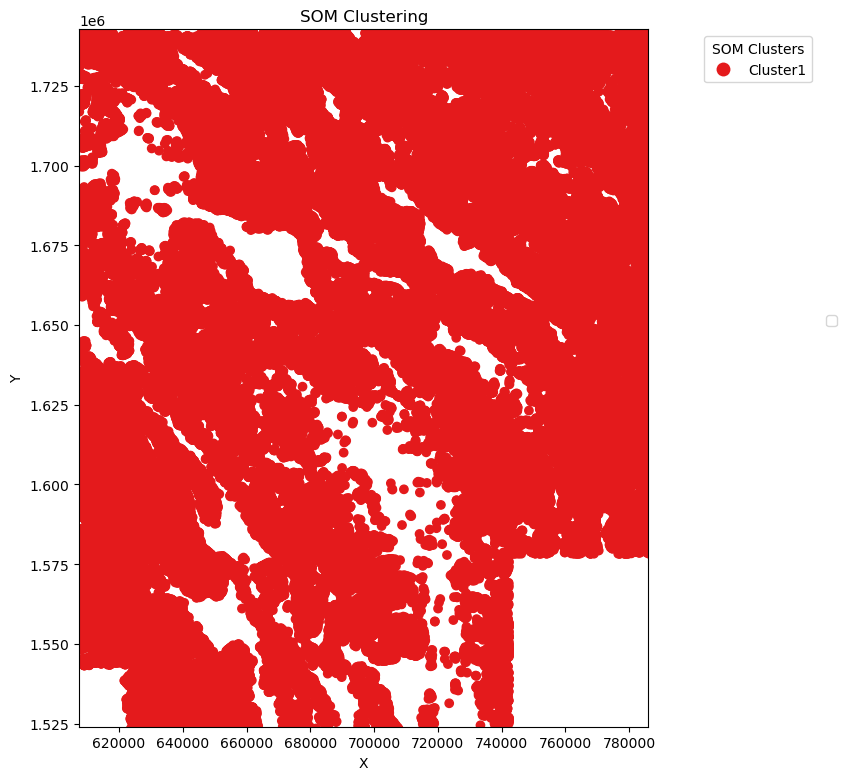

In [219]:
fig, ax = plt.subplots(figsize=(8,8))
df_SOM_gdf[df_SOM_gdf['Cluster']=='Cluster1'].plot(ax=ax,column='Cluster', cmap='Set1', legend=True)

legend1 = ax.get_legend()
if legend1:
    legend1.set_bbox_to_anchor((1.3, 1))  # Move legend further right
    legend1.set_title("SOM Clusters")
legend2 = ax.legend(bbox_to_anchor=(1.3, 0.6), loc='upper left')

# Increase right margin
plt.subplots_adjust(right=0.8)




plt.xlabel("X")
plt.ylabel("Y")
plt.title("SOM Clustering")
ax.set_xlim(607500, 786000)
ax.set_ylim(1524000, 1742700)
ax.add_artist(legend1)
plt.tight_layout()
#plt.savefig("SOM_predictive.jpg")
plt.show()

In [179]:
df_SOM_gdf.to_csv("SOM_predictive.csv")

In [181]:
df_SOM_gdf.head()

Longitude   Latitude  Band_1  Band_2  Band_3  Band_4  Band_5  Band_6  \
0   607550.0  1742650.0     0.0     0.0     0.0     0.0     0.0     0.0   
1   607650.0  1742650.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   607750.0  1742650.0     0.0     0.0     0.0     0.0     0.0     0.0   
3   607850.0  1742650.0     0.0     0.0     0.0     0.0     0.0     0.0   
4   607950.0  1742650.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Band_7  Band_8   Cluster                geometry  
0     0.0     0.0  Cluster9  POINT (607550 1742650)  
1     0.0     0.0  Cluster9  POINT (607650 1742650)  
2     0.0     0.0  Cluster9  POINT (607750 1742650)  
3     0.0     0.0  Cluster9  POINT (607850 1742650)  
4     0.0     0.0  Cluster9  POINT (607950 1742650)

In [183]:
df_SOM_cluster = df_SOM_gdf[['Longitude','Latitude','Cluster','geometry']]

<Axes: >

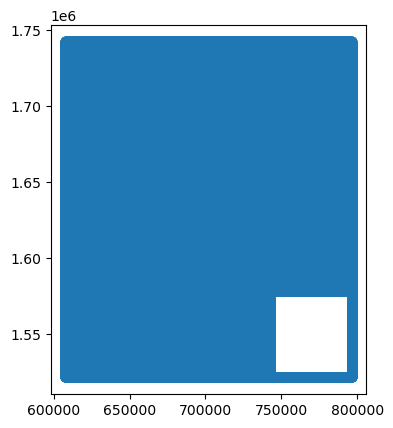

In [187]:
df_SOM_cluster.plot()

In [185]:
df_SOM_cluster.to_file("SOM_predictive.shp")

In [199]:
df_SOM_cluster

Longitude   Latitude   Cluster                geometry
0         607550.0  1742650.0  Cluster9  POINT (607550 1742650)
1         607650.0  1742650.0  Cluster9  POINT (607650 1742650)
2         607750.0  1742650.0  Cluster9  POINT (607750 1742650)
3         607850.0  1742650.0  Cluster9  POINT (607850 1742650)
4         607950.0  1742650.0  Cluster9  POINT (607950 1742650)
...            ...        ...       ...                     ...
4182241   795950.0  1521350.0  Cluster9  POINT (795950 1521350)
4182242   796050.0  1521350.0  Cluster9  POINT (796050 1521350)
4182243   796150.0  1521350.0  Cluster9  POINT (796150 1521350)
4182244   796250.0  1521350.0  Cluster9  POINT (796250 1521350)
4182245   796350.0  1521350.0  Cluster9  POINT (796350 1521350)

[3875526 rows x 4 columns]

In [40]:
import pandas as pd
df_SOM_cluster_predictive = pd.read_csv("SOM_predictive.csv")

In [42]:
import geopandas as gpd

df_SOM_cluster_predictive_gdf = gpd.GeoDataFrame(df_SOM_cluster_predictive, geometry=gpd.points_from_xy(df_SOM_cluster_predictive['Longitude'], df_SOM_cluster_predictive['Latitude']),crs="EPSG:32643")
                                                                                                        
                                                                                                        
                                                                                                        

In [44]:
df_SOM_cluster_predictive_gdf

Unnamed: 0  Longitude   Latitude  Band_1  Band_2  Band_3  Band_4  \
0                 0   607550.0  1742650.0     0.0     0.0     0.0     0.0   
1                 1   607650.0  1742650.0     0.0     0.0     0.0     0.0   
2                 2   607750.0  1742650.0     0.0     0.0     0.0     0.0   
3                 3   607850.0  1742650.0     0.0     0.0     0.0     0.0   
4                 4   607950.0  1742650.0     0.0     0.0     0.0     0.0   
...             ...        ...        ...     ...     ...     ...     ...   
3875521     4182241   795950.0  1521350.0     0.0     0.0     0.0     0.0   
3875522     4182242   796050.0  1521350.0     0.0     0.0     0.0     0.0   
3875523     4182243   796150.0  1521350.0     0.0     0.0     0.0     0.0   
3875524     4182244   796250.0  1521350.0     0.0     0.0     0.0     0.0   
3875525     4182245   796350.0  1521350.0     0.0     0.0     0.0     0.0   

         Band_5  Band_6  Band_7  Band_8   Cluster                geometry  
0           0.0     0.0     0.0     0.0  Cluster9  POINT (607550 1742650)  
1           0.0     0.0     0.0     0.0  Cluster9  POINT (607650 1742650)  
2           0.0     0.0     0.0     0.0  Cluster9  POINT (607750 1742650)  
3           0.0     0.0     0.0     0.0  Cluster9  POINT (607850 1742650)  
4           0.0     0.0     0.0     0.0  Cluster9  POINT (607950 1742650)  
...         ...     ...     ...     ...       ...                     ...  
3875521     0.0     0.0     0.0     0.0  Cluster9  POINT (795950 1521350)  
3875522     0.0     0.0     0.0     0.0  Cluster9  POINT (796050 1521350)  
3875523     0.0     0.0     0.0     0.0  Cluster9  POINT (796150 1521350)  
3875524     0.0     0.0     0.0     0.0  Cluster9  POINT (796250 1521350)  
3875525     0.0     0.0     0.0     0.0  Cluster9  POINT (796350 1521350)  

[3875526 rows x 13 columns]

In [9]:
df_lith = gpd.read_file("lithology_gcs_ngdr_20250224141337303/lithology_gcs_ngdr.shp")

In [18]:
df_lith['lithologic']

0                      ARGILLITE
1       CHLORITE SERICITE SCHIST
2                 FERRO DOLOMITE
3                      LIMESTONE
4                CHLORITE SCHIST
                  ...           
7974                  PYROXENITE
7975                  PYROXENITE
7976                  PYROXENITE
7977                  PYROXENITE
7978                  PYROXENITE
Name: lithologic, Length: 7979, dtype: object

<Axes: >

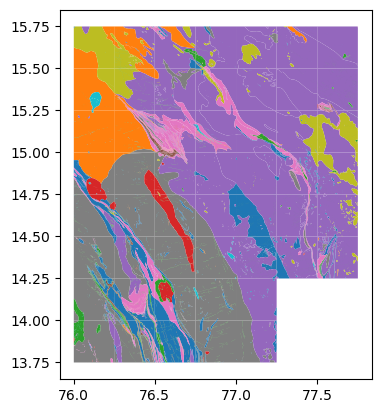

In [22]:
df_lith.plot( column = 'lithologic')


/var/folders/cj/c3lxhrz916l_n171dhdhbg8h0000gp/T/ipykernel_1258/1144096431.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend2 = ax.legend(bbox_to_anchor=(1.3, 0.6), loc='upper left')


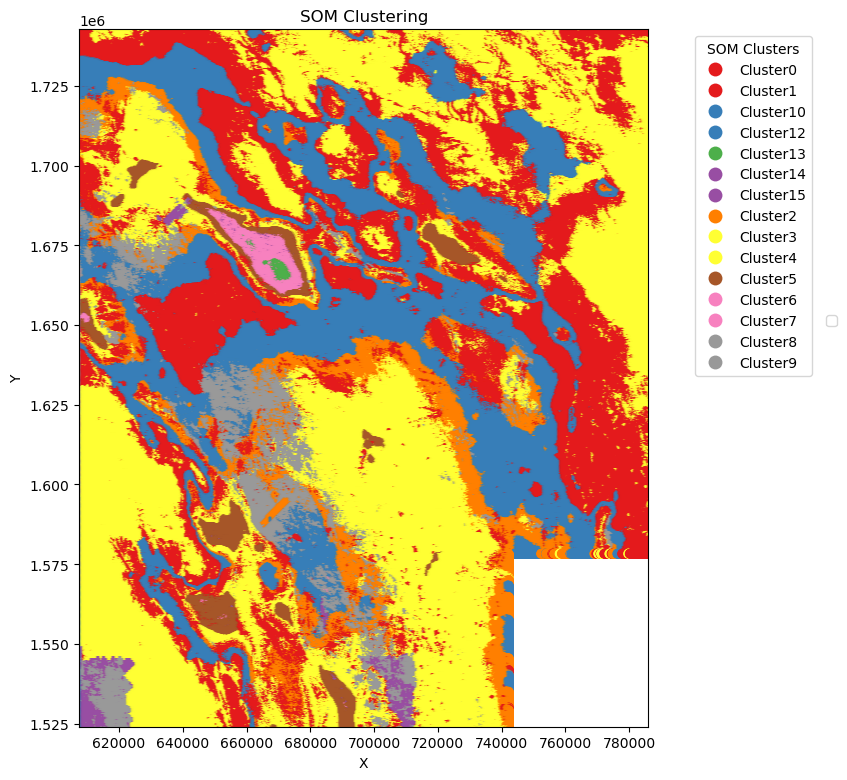

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
df_SOM_cluster_predictive_gdf.plot(ax=ax,column='Cluster', cmap='Set1', legend=True)
legend1 = ax.get_legend()
if legend1:
    legend1.set_bbox_to_anchor((1.3, 1))  # Move legend further right
    legend1.set_title("SOM Clusters")
legend2 = ax.legend(bbox_to_anchor=(1.3, 0.6), loc='upper left')

=plt.subplots_adjust(right=0.8)




plt.xlabel("X")
plt.ylabel("Y")
plt.title("SOM Clustering")
ax.set_xlim(607500, 786000)
ax.set_ylim(1524000, 1742700)
ax.add_artist(legend1)
plt.tight_layout()
#plt.savefig("SOM_predictive.jpg")
plt.show()

In [46]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import numpy as np

resolution = 100  


minx, miny, maxx, maxy = df_SOM_cluster_predictive_gdf.total_bounds

width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)

transform = from_origin(minx, maxy, resolution, resolution)

shapes = [(geom, value) for geom, value in zip(df_SOM_cluster_predictive_gdf.geometry, df_SOM_cluster_predictive_gdf['Cluster'])]

raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    fill=0,  
    transform=transform,
    dtype='int32'
)

with rasterio.open(
    'SOM_cluster_predictive.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs=df_SOM_cluster_predictive_gdf.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)


CRS: EPSG:32643
Bounds: BoundingBox(left=607550.0, bottom=1521350.0, right=796350.0, top=1742650.0)


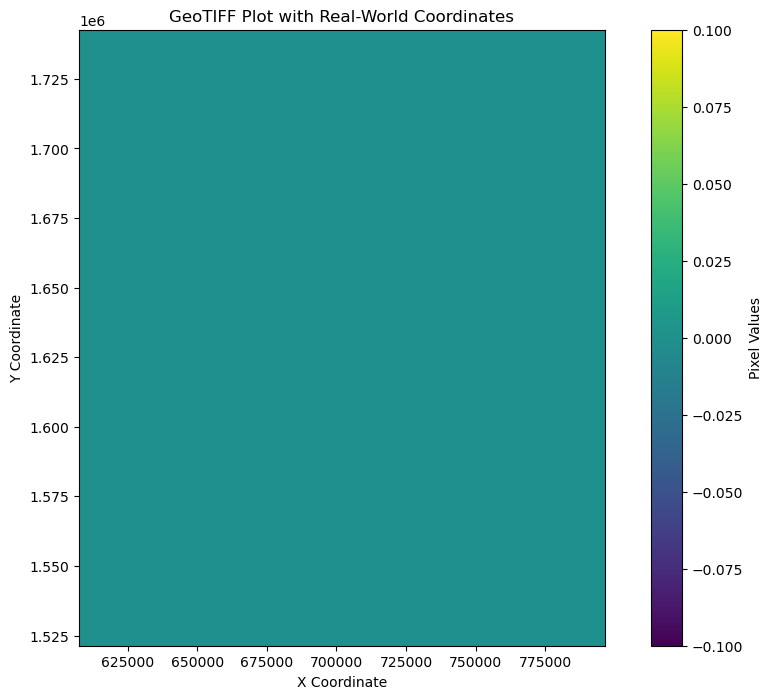

In [48]:
with rasterio.open('SOM_cluster_predictive.tif') as src:
    raster_data = src.read(1)  
    bounds = src.bounds  
    crs = src.crs         
    print(f"CRS: {crs}")
    print(f"Bounds: {bounds}")

    plt.figure(figsize=(12, 8))
    plt.imshow(
        raster_data,
        cmap='viridis',
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top]
    )
    plt.colorbar(label='Pixel Values')
    plt.title('GeoTIFF Plot with Real-World Coordinates')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()